# Introduction

Dendritic spines are an essential structure in dlPFC pyramidal neurons for regulating neuromodulators. Decreased populations of such spines have, for instance, been associated with schizophrenia and other neurological disorders. Studying their effect on excitatory neurotransmission is the goal of this project. Specifically, we want to look into the results of Cornejo, et al. 2022 which finds that although spines follow the voltages of their parent dendrites during action potentials, spines have different voltages during sub-threshold/resting potential states.

- Essential for preserving representations in dlPFC for delay cells.



In [1]:
from brian2 import *

## Quick BRIAN trial

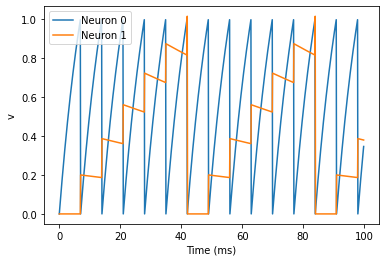

In [2]:
# SKIP THIS CELL if you don't want to confuse the later cells...
start_scope()

eqs = '''
dv/dt = (I - v)/tau: 1
I : 1
tau : second
'''

G = NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method = 'exact')
G.I = [2, 0]
G.tau = [10, 100]*ms

# Synapse
S = Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i = 0, j = 1)

M = StateMonitor(G, 'v', record=True)

run(100*ms)

plot(M.t/ms, M.v[0], label = 'Neuron 0')
plot(M.t/ms, M.v[1], label = 'Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend();

# Establishing the basics

A simple model inclduing a neuron group: a spine on a dendrite attached to a soma

**Goal:** try to replicate spontaneous voltage potential in spine only.

In [3]:
# Morphology Params
# These default values are from Lagache et al. 2019. I take the average of a range of values cited.

d_spine_head = 0.4 # um
l_spine_neck = 0.4 # um
d_spine_neck = 0.1 # um

d_soma = 30 # um
d_dendrite = 1 # um
l_dendrite = 100 # um

morph = Soma(diameter = d_soma*um)
morph.dendrite = Cylinder(diameter = d_dendrite*um, length = l_dendrite*um, n = 6)
morph.dendrite.spine = Cylinder(diameter = d_spine_neck*um, length = l_spine_neck*um, n = 1)
morph.dendrite.spine.head = Soma(diameter = d_spine_head*um)

morph.topology()

( )  [root] 
   `------|  .dendrite
           `-|  .dendrite.spine
              `( )  .dendrite.spine.head

In [4]:
# Task: figure out a good way to visualize quickly

new_morpho = morph.generate_coordinates()

The key state variable, which must be specified at construction, is $I_m$. It is the total transmembrane current, expressed in units of current per area. This is a mandatory line in the definition of the model.

At every timestep, Brian integrates the state variables, calculates the transmembrane current at every point on the neuronal morphology, and updates v using the transmembrane current and the diffusion current, which is calculated based on the morphology and the intracellular resistivity.

In [5]:
start_scope()
defaultclock.dt = 0.05*ms

gL = 1e-4*siemens/cm**2
EL = -70*mV
Cm=1*uF/cm**2 # specific membrane capacitance
Ri=100*ohm*cm # intracellular resistivity
N = 400

thres = 'v > 0*mV'
ref = 'v > -10*mV'

eqs = '''
Im = gL * (EL - v) : amp/meter**2
I : amp (point current)
'''

In [6]:
neuron = SpatialNeuron(morphology=morph, model=eqs, Cm=Cm, Ri=Ri, threshold = thres, 
                       threshold_location = 0, refractory = ref)

In [7]:

neuron.v = EL
taum = Cm / gL # membrane time constant
print("Time constant: %s" % taum)
la = neuron.space_constant[0]
print("Characteristic length: %s" % la)

# Actual simulation
mon = StateMonitor(neuron, 'v', record = True)
spikes = SpikeMonitor(neuron)

run(10*ms, report = 'text')
neuron.I[8] = 1*nA # inject current at spine head
run(0.02*ms)
neuron.I = 0*amp
run(10*ms, report='text')

t = mon.t

Time constant: 10. ms
Characteristic length: 14.40977202 mm
Starting simulation at t=0. s for a duration of 10. ms
10. ms (100%) simulated in < 1s
Starting simulation at t=10.02 ms for a duration of 10. ms
10. ms (100%) simulated in < 1s


In [8]:
len(mon.v)

9

WARNING    /var/folders/nv/w1hsrq1s4wx19t3hqby38n2c0000gn/T/ipykernel_8478/1875838613.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax[0].plot(t/ms, mon.v[0].T/mV, 'k', c = 'red', label = "Soma")
 [py.warnings]
WARNING    /var/folders/nv/w1hsrq1s4wx19t3hqby38n2c0000gn/T/ipykernel_8478/1875838613.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax[1].plot(t/ms, mon.v[1:8].T/mV, 'k', c = 'blue', alpha = 0.1,label = "Dendrite")
 [py.warnings]
WARNING    /var/folders/nv/w1hsrq1s4wx19t3hqby38n2c0000gn/T/ipykernel_8478/1875838613.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax[2].plot(t/ms, mon.v[8].T/

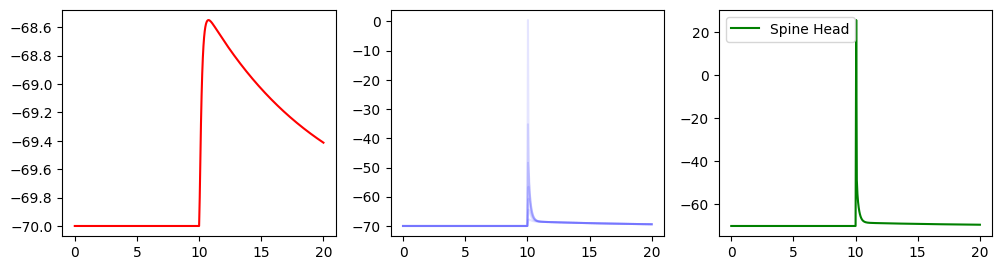

In [9]:
fig, ax = plt.subplots(1,3, figsize = (12,3), dpi = 100)
ax[0].plot(t/ms, mon.v[0].T/mV, 'k', c = 'red', label = "Soma")
ax[1].plot(t/ms, mon.v[1:8].T/mV, 'k', c = 'blue', alpha = 0.1,label = "Dendrite")
ax[2].plot(t/ms, mon.v[8].T/mV, 'k', c = 'green', label = "Spine Head")
plt.legend()

# Neuromodulation in dlPFC

**calcium-cAMP-PKA**
- cAMP-PKA signaling can increase RyR and IP3 receptors which increases Ca2+
- Ca2+ in cytosol generates cAMP (feedforward cycling)
- K+ channels (HCN, KCNQ) open with cAMP and PKA

**Acetylcholine**
Acts at 
- Nic $\alpha$ 7R: Ion channels (Ca+)
- M1R within the glutamate synapse: Indirect, closes neighboring K+ channels / increases Ca2+ release near the synapse via IP3 signaling / at high levels may excite GABAergic interneurons, or may open K+ channels indirectly (IP3)

**Dopamine**
- D1R have been shown to enhance NMDAR actions -> enhance calcium flux.

**Noradrenaline**
- moderate levels engage $\alpha$2A-AR: strengthens delay cell firing via inhibition of cAMP-K+ signaling
- high levels engage $\alpha$1A-AR: weakens delay cell firing (?)

**Serotonin**
-?


### A minimal set of channels
Membrane: K+ (leak - membrane),\
HEAD: AMPAR (Na), NMDA (Na, Ca2+), Nic-a7R (also Ca2+)\
NECK: KCNQ, HCN\

- Need calcium buffering
- components/processes needed; candidate models
- flow diagram for electrical shunting

- effective spine neck resistance is something measurable.
- How strong do the conductances need to be in order to give a dynamic range of effective synaptic strength.

dendrite + spine potential + putting ambient nmda potentials on the dendrite

The following builds off of **Brunel and Wang 2001**.

Here we will use leaky integrate-and-fire neurons which are characterized by a resting potential and a $V_L = -70 \text{mV}$ and a firing threshold $V_{thr} = -50 \text{mV}$, a reset potential $V_{reset} = -55 \text{mV}$ and a membrane capacitance of $C_m = 0.5 \text{nF}$, a membrane eleak conductance $g_m = 35 \text{nS}$, and a refractory period $\tau_{rp} = 2 \text{ms}$

Consider using synapses and dividing up the current received by each compartment based on which synapse it enters through.
<br>

---
**Membrane**: \
$ I_{leak} = gL\,(V - V_L) $ (General leak channel) \
\
**Head**: \
$I_{AMPA} = g_A (V - V_E) s_A$ \
$I_{NMDA} = \frac{g_N (V - V_E)}{1 + \text{Mg}^{2+}\text{exp}(-0.062 V)/3.57}s_{N}$ \
Unclear if I can treat nicotinic alpha 7 as a channel... \
$I_{Nic} = g_{Nic} (V - V_{Nic}) s_{Nic}$  (Nic-A7 is Ca concentration independent) \
\
**Neck**: \
$ I_{KCNQ} $ 

To keep track of Ca levels:
Approximately 10% of the current through NMDA channels is carried by calcium (Jahr and Steves, 1993).







### modified LIF equations

\begin{align*}
\frac{dv}{dt} &= \frac{-g_m (V - V_L) - I_{syn}}{C_m}\\
I_{syn} &= I_{AMPA} + I_{NMDA,Ca} + I_{NMDA,Na}\\
\end{align*}

Where we define
\begin{align*}
I_{AMPA} &= g_{AMPA} * (v - V_{AMPA}) * s_{AMPA}\\
\frac{ds_{AMPA}}{dt} &= - s_{AMPA} / \tau_{AMPA}\\
I_\text{NMDA} &= \frac{g_\text{NMDA} * (v - V_\text{NMDA}) * s_{\text{NMDA}}}{1 + \text{Mg2} e^{-0.062 v}/3.57}
\frac{ds_\text{NMDA}}{dt} = 
\end{align*}


I also need a dynamic equation for $[Ca2+]$
\begin{equation}
\frac{d[\text{Ca}^{2+}]}{dt} = - w*[\text{Ca}^{2+}]
\end{equation}


## Neuron Group instead of Multicompartment

Unfortunately, the spatially extended neuron class does not allow us to specify an individual compartment's intracellular resistivity, so here we instead use separate neuron groups to indicate voltage compartmentalization

Spatial soma + dendrite (It's okay if this is isopotential, but I might want to change this later on).

Spine is composed of two separate 'neurons'. One neck (for intracellular neck resistivity = high) and one head. The output current from the head is directly fed into the neck.

In [28]:

def run_trial(i):
    start_scope()

    V_reset = -55. * mV
    V_thr = -50. * mV
    V_K = -30. * mV
    V_L = -70. * mV
    C_m = 0.5 * nF
    gL = 25. * nS

    eqs_soma = '''
    dv / dt = (- gL * (v - V_L) - I) / C_m : volt
    I : amp (linked)
    tau : second
    '''

    eqs_spine_head = ''' 
    dv / dt = (- gL * (v - V_L) - I) / C_m : volt
    I : amp
    tau : second
    '''

    eqs_spine_neck = '''
    dv / dt = (- gL * (v - V_L) - I_syn) / C_m : volt
    I_syn = I - IK : amp
    IK = gK * (v - V_K) : amp
    gK : siemens
    I : amp (linked)
    tau : second
    '''

    soma = NeuronGroup(1, eqs_soma, threshold='v > V_thr', reset='v = V_reset', method = 'exact')
    spine_neck = NeuronGroup(1, eqs_spine_neck)
    spine_head = NeuronGroup(1, eqs_spine_head)
    spine_neck.I = linked_var(spine_head, 'I')
    soma.I = linked_var(spine_neck, 'I_syn')

    # Initial system set up
    soma.v = V_L
    spine_head.v = V_L
    spine_neck.v = V_L
    run(10*ms)

    spine_neck.gK = 0 * nS

    soma.tau = 10*ms
    spine_head.tau = 100*ms
    spine_neck.tau = 100*ms

    M_soma = StateMonitor(soma, ['v', 'I'], record=True)
    M_spine_head = StateMonitor(spine_head, ['v', 'I'], record=True)
    M_spine_neck = StateMonitor(spine_neck, ['v', 'IK', 'I', 'I_syn'], record=True)

    # Starting the simulation
    run(100*ms)
    spine_head.I = i * nA
    run(200*ms)

    fig, axs = plt.subplots(1,2, figsize = (15,5))
    fig.suptitle(str(i))
    axs[0].plot(M_soma.t/ms, M_soma.v[0]    , label = 'soma')
    axs[0].plot(M_spine_neck.t/ms, M_spine_neck.v[0], label = 'spine neck')
    axs[0].plot(M_spine_head.t/ms, M_spine_head.v[0], label = 'spine head')
    axs[0].legend()

    axs[1].plot(M_spine_neck.t/ms, M_spine_neck.IK[0], label = "IK")
    axs[1].plot(M_spine_neck.t/ms, M_spine_neck.I[0], label = "Neck I_syn")
    axs[1].plot(M_spine_head.t/ms, M_spine_head.I[0], label = "Head I")
    axs[1].plot(M_soma.t/ms, M_soma.I[0], label = "Soma I")
    axs[1].legend()

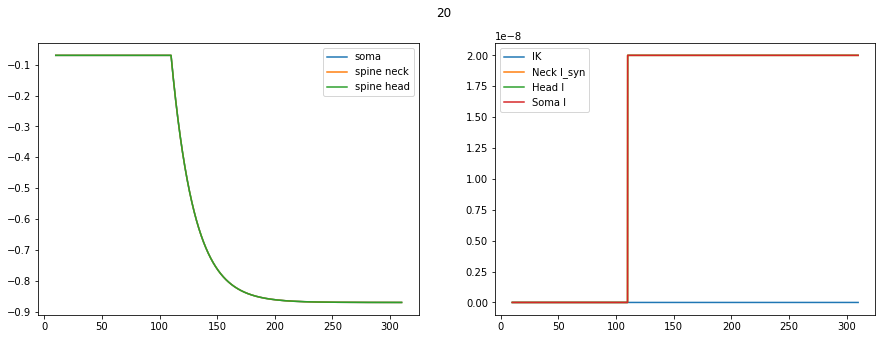

In [29]:
run_trial(20)